In [1]:
import pickle
import copy

import alphashape as ashp
import pandas as pd
import numpy as np
import colorcet as cc
import geopandas as gpd
import matplotlib.pyplot as plt

from filterpy.kalman import IMMEstimator, KalmanFilter, MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF
from scipy.linalg import block_diag

from tqdm import tqdm
from matplotlib import colors
from pyproj import Proj

In [2]:
plt.style.use('dark_background')

In [3]:
H5_PATH = '/home/yang/data/gps/'
OUTPUT_PATH = '/home/yang/output/eswe/imm/'
EVENT = 'jkwh'
MACHINE_ID = '2388'
DATE = '072019'
FIELD_ID = 'f8'
log_name = '-'.join([EVENT, MACHINE_ID, DATE, FIELD_ID, 'gps.h5'])

In [4]:
gps = pd.read_hdf(H5_PATH + log_name)

In [5]:
gps.head()

,machine_id,ts,lat,lon,alt,speed,track,accuracies,x,y,ts_local
0,joe 2388,1297319541,40.778553,-102.325032,1140.000000,0.00,0.0,11,725732.363209,4.517618e+06,2011-02-09 23:32:21
1,joe 2388,1297319542,40.778525,-102.325060,1140.099976,0.00,0.0,11,725730.127124,4.517615e+06,2011-02-09 23:32:22
2,joe 2388,1297319543,40.778490,-102.325084,1140.000000,0.00,0.0,11,725728.175426,4.517611e+06,2011-02-09 23:32:23
3,joe 2388,1297319544,40.778540,-102.325050,1140.000000,0.00,0.0,12,725730.864839,4.517616e+06,2011-02-09 23:32:24
4,joe 2388,1297319572,40.778660,-102.325071,1134.199951,0.25,263.4,28,725728.732359,4.517630e+06,2011-02-09 23:32:52


(725648.7497883784, 726105.6736693224, 4517530.55878798, 4519292.470012943)

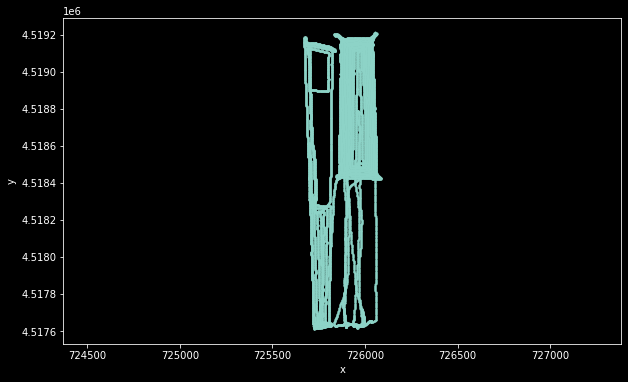

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
gps.plot.scatter(x='x', y='y', s=1, ax=ax)
ax.axis('equal')

In [7]:
# Before filteing, let's see if there is any gap in data points
# We need to break these different segments into groups and then smooth each group

# Compute time difference
gps_seg = gps.copy()
gps_seg['ts_diff'] = gps_seg['ts'].diff()
gps_seg.loc[0, 'ts_diff'] = 0

# A trick vector that could be used for grouping
gps_seg['ts_diff_binary'] = gps_seg['ts_diff'] > 1
gps_seg['ts_diff_binary_cumsum'] = gps_seg['ts_diff_binary'].apply(lambda x: 1 if x else 0).cumsum()

# Points groups
grp = gps_seg.groupby('ts_diff_binary_cumsum')

# Make indices right
gps_seg['seg_num'] = grp.ngroup()
gps_seg.loc[0, 'seg_num'] = 0

In [8]:
print(gps_seg['seg_num'].unique())

[ 0  1  2  3  4  5  6  7  8  9 10]


In [9]:
# Allocate space for model probs.
gps_c = gps.copy()
gps_c['cv_prob'] = np.nan
gps_c['nct_prob'] = np.nan

In [10]:
# # Get the measured value vector
# Z = np.vstack([gps['x'].values, gps['y'].values]).T

In [11]:
# Define timestep
dt = 1

In [12]:
# UKF f, h definitions
def f_nct(x, dt):
    F = np.array([[1, np.sin(x[4]*dt)/x[4], 0,  -(1-np.cos(x[4]*dt))/x[4], 0], \
                  [0, np.cos(x[4]*dt), 0, -np.sin(x[4]*dt), 0], \
                  [0, (1-np.cos(x[4]*dt))/x[4], 1, np.sin(x[4]*dt)/x[4], 0], \
                  [0, np.sin(x[4]*dt), 0, np.cos(x[4]*dt), 0], \
                  [0, 0, 0, 0, 1]], dtype=float)
    return F@x

def h_nct(x):
    H = np.array([[1, 0, 0, 0, 0], \
                  [0, 0, 1, 0, 0]], dtype=float)
    return x[[0,2]]

In [13]:
# Setup UKF for NCT model
points = MerweScaledSigmaPoints(n=5, alpha=.1, beta=2., kappa=-1)
nct = UKF(dim_x=5, dim_z=2, dt=dt, fx=f_nct, hx=h_nct, points=points)
nct.x = np.array([0, 0, 0, 0, 0.1])
nct.P *= 1.e-3
# nct.R = np.diag([1e-1, 1e-1])
nct.R = np.diag([0.5, 0.5])
# q_nct = np.radians(1)
q_nct = 0.01
nct.Q = np.array([[0, 0, 0, 0, 0], \
                  [0, 0, 0, 0, 0], \
                  [0, 0, 0, 0, 0], \
                  [0, 0, 0, 0, 0], \
                  [0, 0, 0, 0, dt*q_nct]])

In [14]:
# Define NCV model
cv = KalmanFilter(5, 2) # we are 5 estimated states, and 2 measured states
# Define dynamic matrix
cv.F = np.array([[1, dt, 0, 0, 0], \
                 [0, 1, 0, 0, 0], \
                 [0, 0, 1, dt, 0], \
                 [0, 0, 0, 1, 0], \
                 [0, 0, 0, 0, 0]])
# Define measurement matrix
cv.H = np.array([[1, 0, 0, 0, 0],
                 [0, 0, 1, 0, 0]])
# Initial state estimate guess
cv.x = np.array([0, 0, 0, 0, 0])
# Initial error covariance guess
cv.P *= 1e-3
# Measurement noise
# cv.R = np.diag([1e-1, 1e-1])
cv.R = np.diag([0.5, 0.5])
# Process noise
q_cv = 1e-3
cv.Q = np.array([[1/3*(dt**3), 1/2*(dt**2), 0, 0, 0], \
                 [1/2*(dt**2), dt, 0, 0, 0], \
                 [0, 0, 1/3*(dt**3), 1/2*(dt**2), 0], \
                 [0, 0, 1/2*(dt**2), dt, 0], \
                 [0, 0, 0, 0, 0]])*q_cv

In [393]:
# Create filter banks
filters = [cv, nct]
# Assign initial mixing probs.
mu = np.array([1/2, 1/2])
# Define model transition prob. matrix
pij = np.array([[0.95, 0.05], \
                [0.05, 0.95]])
bank = IMMEstimator(filters, mu, pij)

In [394]:
for n in tqdm(gps_seg['seg_num'].unique()):
    # Get the track segment
    seg = gps_seg.loc[gps_seg['seg_num'] == n, ['x', 'y']]
    z = np.vstack([seg['x'].values, seg['y'].values]).T
    xs, probs = [], []
    # Filter data with IMM
    cv.x = np.array([z[0,0], 0, z[0,1], 0, 0])
    nct.x = np.array([z[0,0], 0, z[0,1], 0, 0.1])
    for i, zi in enumerate(z):
        bank.predict()
        bank.update(zi)
        xs.append(bank.x.copy())
        probs.append(bank.mu.copy())
    # Put the model prob. and IMM combined states as np arrays
    probs = np.array(probs)
#     xs = np.array(xs)
    # Assign the model probs. to the original df
    gps_c.loc[gps_seg[gps_seg['seg_num'] == n].index, 'cv_prob'] = probs[:,0]
    gps_c.loc[gps_seg[gps_seg['seg_num'] == n].index, 'nct_prob'] = probs[:,1]

100%|██████████| 11/11 [00:42<00:00,  3.85s/it]


(725648.7497883784, 726105.6736693224, 4517530.55878798, 4519292.470012943)

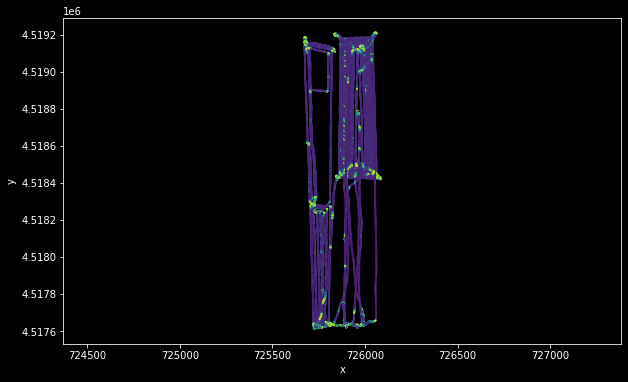

In [395]:
fig, ax = plt.subplots(figsize=(10,6))
gps_c.plot.scatter(x='x', y='y', c='nct_prob', cmap=plt.get_cmap('viridis'), colorbar=False, s=1, ax=ax)
ax.axis('equal')

In [396]:
# Save the model probs. into the dataframe and save it
gps_c.to_hdf(OUTPUT_PATH + '-'.join([EVENT, MACHINE_ID, DATE, FIELD_ID, 'gps-imm.h5']), key='df', mode='w')